# Rozhodovací stromy: učení se z dat
  
  * V tomto notebooku byste se měli naučit, jak vytvořit (naučit) model dat ve formě rozhodovacího stromu.
  * Ukážeme si typický způsob, jak se toto dělá a představíme si i základní API knihovny `sklearn`.
  * Začneme s daty a skončíme s naučeným modelem, o kterém budeme tušit, jak je dobrý.

In [1]:
import math
import pandas as pd
import numpy as np

## Data: základní přehled

  * Použijeme balíček `pandas` k nahrání dat a jejich základnímu prozkoumání.
  * Data jsme stáhli ze serveru **kaggle.com**, kde můžete také najít [popis jednotlivých příznaků](https://www.kaggle.com/uciml/adult-census-income).

In [2]:
data = pd.read_csv('adult-census.csv')
display(data.shape)
display(data.head())
display(data.info())
display(data.describe())
display(data.nunique()) # počet unikátních hodnot, defaultně ignoruje NaNs

(32561, 15)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

### Chybějící hodnoty

  * Některé příznaky jsou očividně nevyplněné, ale `pandas` hlásí, že žádné nechybí. Je to tím, že chybějící hodnoty nejsou zakódované jako `NaN` ale jsou nahrazeny otazníkem `?`.

In [3]:
data = data.replace('?', np.nan)
# podívejme se na výsledek
data.info()
data.isnull().sum(axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


0        2
1        0
2        2
3        0
4        0
        ..
32556    0
32557    0
32558    0
32559    0
32560    0
Length: 32561, dtype: int64

## První pokus o použití rozhodovacího stromu implementovaného v `sklearn`

    

 * [Zde](http://scikit-learn.org/stable/modules/tree.html) najdete dokumentaci k rozhodovacím stromům v balíčku `tree` knihovny `scikit-learn`.
 * Naším cílem je pouze zjistit, jestli už máme data připravená k tomu, aby si s nimi tato implementace poradila.

In [4]:
from sklearn.tree import DecisionTreeClassifier
# uložíme si vysvětlovanou proměnnou (poslední sloupec income) a příznaky
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1] 

  * V knihovně `scikit-learn` mají modely jednotný interface (API).
  * Nejdříve se vždy nastaví hyperparametry modelu (jaké jsou k dispozici lze zjistit pomocí nápovědy) a "nastavený" model se uloží do proměnné:

In [5]:
dt = DecisionTreeClassifier()
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier()>

  * Model se pak "naučí" na datech pomocí metody `.fit()`. 
  * V případě supervizovaných modelů vyžaduje většinou matici (`pandas.DataFrame`) s příznaky a vektor (`pandas.Series`) s vysvětlovanou proměnnou.

  * **Ajajaj, nefunguje to:** implementace rozhodovacího stromu v `sklearn` si neumí poradit s nečíselnými (nenumerickými) příznaky.
  * Musíme proto nahradit stringy nějakými jejich kódy.
  * **ÚKOL:** Zjistěte, jaký je vztah mezi příznaky *education* a *education.num*. 

In [6]:
### sem přijde Váš kód
data['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [7]:
data['education.num'].value_counts()

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education.num, dtype: int64

In [8]:
def find_mapping_between_columns(data: pd.DataFrame) -> pd.Series:
    education_counts = data['education'].value_counts()
    education_num_counts = {y:str(x) for x,y in data['education.num'].value_counts().to_dict().items()}
    
    return education_counts.map(education_num_counts)

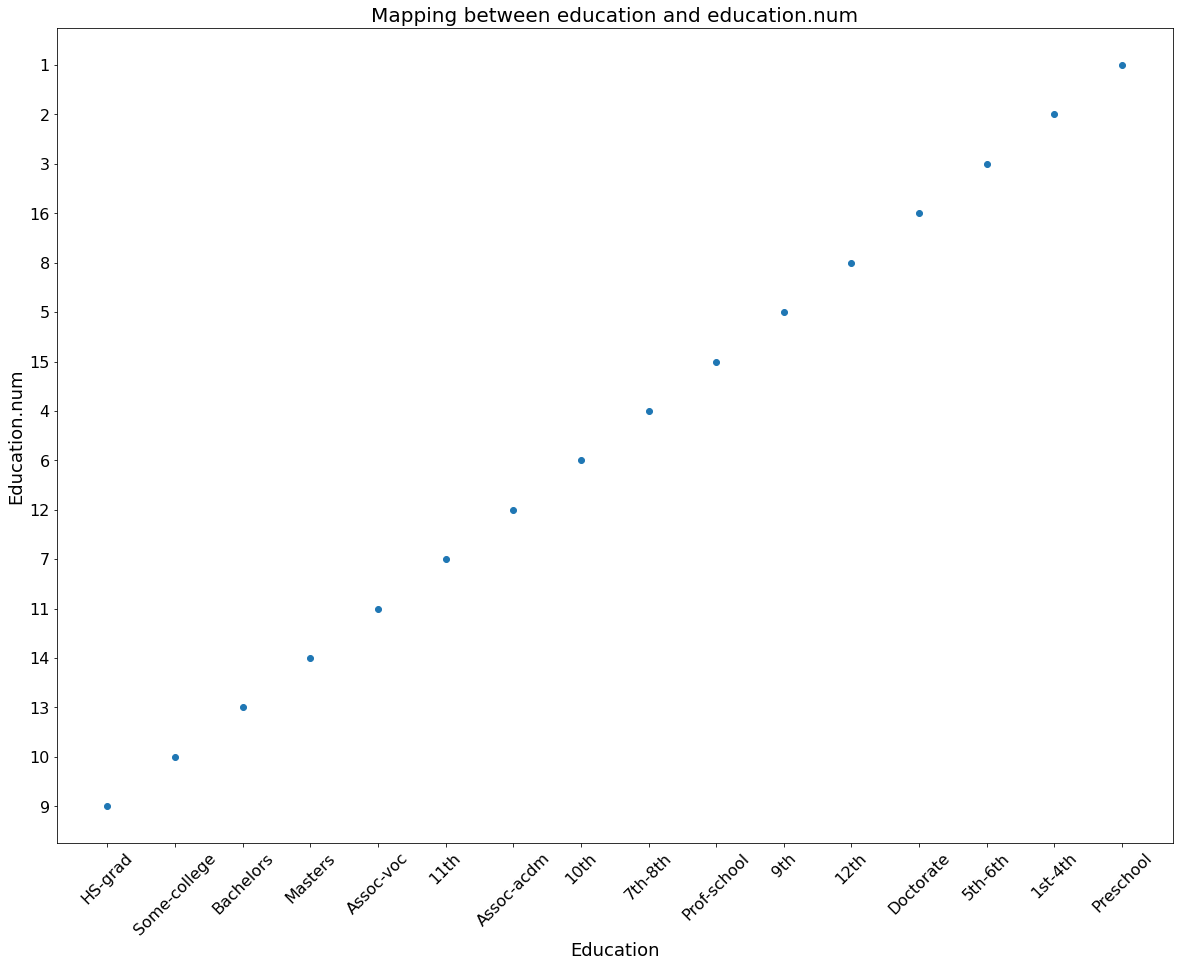

In [9]:
import matplotlib.pyplot as plt

mapping = find_mapping_between_columns(data)

plt.figure(figsize=(20,15))
plt.scatter(mapping.index, mapping)
plt.xlabel("Education", fontsize=18)
plt.ylabel("Education.num", fontsize=18)
plt.title("Mapping between education and education.num", fontsize=20)

plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)

plt.show()

* Úprava data pro použití v rozhodovacím stromu

In [10]:
data.drop(columns=['education'], inplace=True)

In [11]:
display(data.dtypes)
display(data.nunique())
string_cols = data.select_dtypes(['object']).columns
print(string_cols)
data[string_cols].nunique()

age                int64
workclass         object
fnlwgt             int64
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

age                  73
workclass             8
fnlwgt            21648
education.num        16
marital.status        7
occupation           14
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       41
income                2
dtype: int64

Index(['workclass', 'marital.status', 'occupation', 'relationship', 'race',
       'sex', 'native.country', 'income'],
      dtype='object')


workclass          8
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
income             2
dtype: int64

  * Všechny příznaky s hodnotami typu string nejsou spojité, ale tzv. **kategorické** (diskrétní).
  * Můžeme je tedy všechny nahradit číselnými kódy.
  * Je v `pandas` nějaká metoda, která to umí? Samozřejmě ano. Je ale nutné typ příznaku v `pandas` změnit na `category`.

In [12]:
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)
data.info()
# funguje to?
data["native.country"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int8 
 2   fnlwgt          32561 non-null  int64
 3   education.num   32561 non-null  int64
 4   marital.status  32561 non-null  int8 
 5   occupation      32561 non-null  int8 
 6   relationship    32561 non-null  int8 
 7   race            32561 non-null  int8 
 8   sex             32561 non-null  int8 
 9   capital.gain    32561 non-null  int64
 10  capital.loss    32561 non-null  int64
 11  hours.per.week  32561 non-null  int64
 12  native.country  32561 non-null  int8 
 13  income          32561 non-null  int8 
dtypes: int64(6), int8(8)
memory usage: 1.7 MB


array([38, -1, 25, 11, 39,  2, 35, 18, 29, 37,  1, 34, 14, 32, 30, 19,  8,
       10, 21, 23, 16, 15,  4, 20,  0, 28, 26,  5, 13,  7, 17,  3, 12, 22,
        6,  9, 40, 33, 31, 24, 36, 27], dtype=int8)

  * A teď to můžeme zkusit s `DecisionTreeClassifier` znovu!
  * Co se stalo s `NaN` položkami?

In [13]:
data.occupation.unique()
data.groupby(["occupation"]).size() # ve sloupci occupation bylo 1843 chybějících hodnot

occupation
-1     1843
 0     3770
 1        9
 2     4099
 3     4066
 4      994
 5     1370
 6     2002
 7     3295
 8      149
 9     4140
 10     649
 11    3650
 12     928
 13    1597
dtype: int64

**Chybějící hodnoty byly nahrazeny -1!**

Jak se vypořádat s chybějícími hodnotami je docela věda. Jejich nahrazení jedinou unikátní hodnotou je takový nejjednodušší (a skutečně používaný) způsob.

## Druhý pokus o použití rozhodovacího stromu

In [14]:
dt = DecisionTreeClassifier()
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier()>

In [15]:
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1]

# pro případ, kdy vysvětlována proměnná není v posledním sloupci
Xdata2 = data.drop(columns='income')
ydata2 = data.income

In [16]:
# porovnání výsledků iloc a drop
print(Xdata.equals(Xdata2))
print(ydata.equals(ydata2))

True
True


In [17]:
dt.fit(Xdata, ydata)

DecisionTreeClassifier()

## Učení stromu

  * Cílem je vytvořit rozhodovací strom, který bude předpovídat *income* daných osob.
  * Chceme také najít nejlepší hodnoty parametrů `max_depth` a `criterion` metody `DecisionTreeClassifier`. Takovýmto parametrům metody se říká *hyperparametery*.
  * Jak víme z přednášky, správný způsob ladění hyperparametrů vyžaduje rozdělení dat na trénovací, validační a testovací.
  * A samozřejmě v `sklearn` je na to balíček.

In [18]:
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

původní data


(32561, 13)

(32561,)

trénovací data


(24420, 13)

(24420,)

testovací data


(8141, 13)

(8141,)

In [19]:
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
print('nové trénovací data')
display(Xtrain.shape)
display(ytrain.shape)
print('validační data')
display(Xval.shape)
display(yval.shape)

nové trénovací data


(18315, 13)

(18315,)

validační data


(6105, 13)

(6105,)

### Měření trénovací chyby pomocí klasifikační přesnosti

In [20]:
dt = DecisionTreeClassifier(max_depth=200)
dt.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=200)

  * Rozhodovací strom máme hotový, nyní můžeme použít metodu `predict()`, abychom získali predikce, které dává strom pro trénovací data.

In [21]:
ypredicted = dt.predict(Xtrain)
np.unique(ypredicted)

array([0, 1], dtype=int8)

In [22]:
(ytrain - ypredicted).value_counts(normalize=True)

0    0.999945
1    0.000055
Name: income, dtype: float64

  * Přesnost na trénovacích datech je  (pro `max_depth` = 50) skoro 100 %! 
  * Měřit přesnost a různé metriky nemusíme takto ručně, v `sklearn` je na to samozřejmě balíček:

In [23]:
import sklearn.metrics as metrics
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))

accuracy score (train): 0.999945


S testovacími daty to tak skvěle nedopadne:

In [24]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.814642


### Ladění hyperparameterů `max_depth` a `criterion`

  * Začněme s hyperparametrem `max_depth`.
  * Jak víme, budeme používat validační množinu.
  * Prozkoumáme hodnoty od 1 do 100.

In [25]:
val_acc = []
train_acc = []
depths = range(1,101)
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

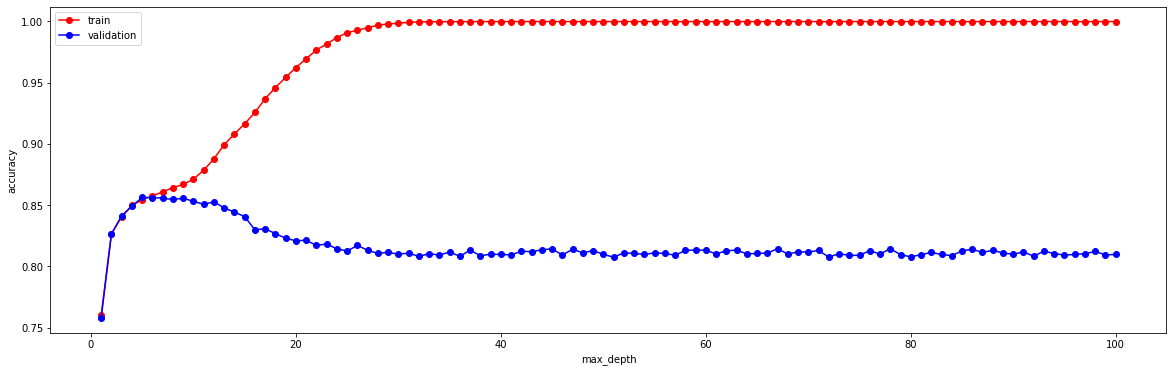

In [26]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(depths, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(depths, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [27]:
optimal_depth = np.argmax(val_acc) + 1
optimal_depth

5

Spočítejme **testovací accuracy** pro nejlepší nalezenou hodnotu `max_depth`:

In [28]:
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(Xtrain, ytrain)
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.851861


### Grid search: ladění více hyperparameterů

  * Chceme projít hodnoty `max_depth` z intervalu [1, 30] a obě možné hodnoty `criterion`, tj. 60 různých kombinací.
  * Můžeme samozřejmě použít dva vnořené for cykly (což je hrozné) nebo použít `ParameterGrid` balíček.

In [29]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,31), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)
# pro lepší pochopení:
[param_comb[i] for i in range(2)]

[{'max_depth': 1, 'criterion': 'entropy'},
 {'max_depth': 2, 'criterion': 'entropy'}]

In [30]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

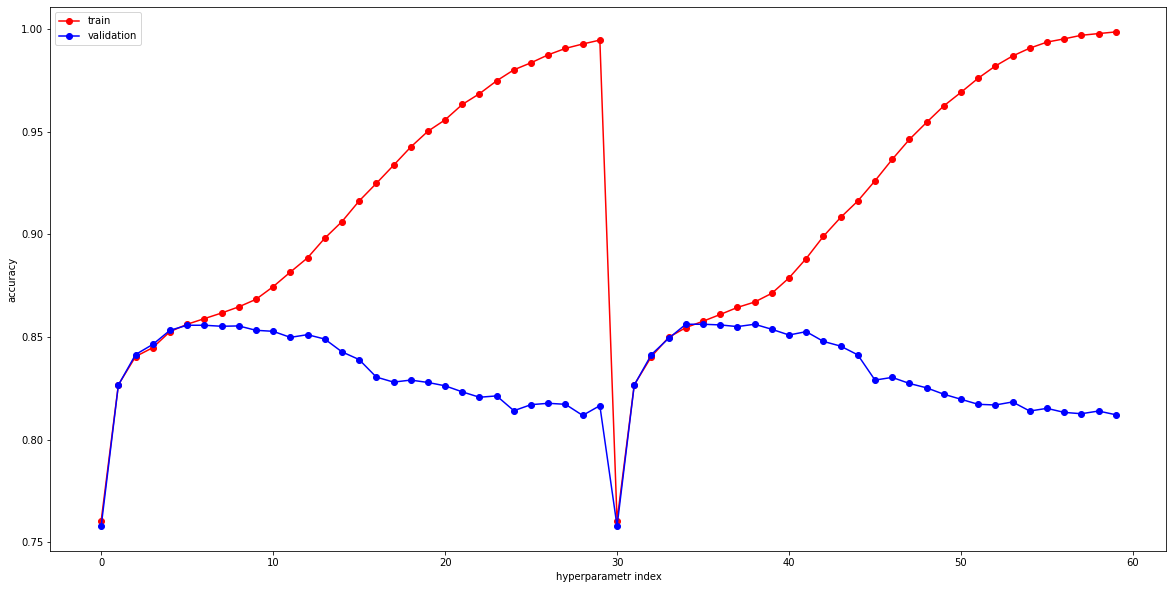

In [31]:
plt.figure(figsize=(20,10))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

In [32]:
best_params = param_comb[np.argmax(val_acc)]
print(best_params)
print(val_acc[np.argmax(val_acc)])
print(train_acc[np.argmax(val_acc)])

{'max_depth': 5, 'criterion': 'gini'}
0.8561834561834561
0.8545454545454545


In [33]:
dt = DecisionTreeClassifier(**best_params) # TOHOTO ŘÁDKU si všimněte: dvě hvězdišky jsou mocný nástroj
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.854545
accuracy score (validation): 0.856183
accuracy score (test): 0.851861


In [34]:
# ukázka operátoru **
def add(b=0, a=0):
    print(a + b) 

d = {
    'a': 1,
    'b': -2
}

c = [1, -2]

add(**d)

-1


In [35]:
import eli5
from IPython.display import display

In [36]:
exp = eli5.show_weights(dt)

In [37]:
exp

Weight,Feature
0.4475,x6
0.2396,x9
0.2273,x3
0.0578,x10
0.0130,x0
0.0116,x11
0.0028,x5
0.0005,x2
0,x12
0,x8


### ÚKOL: naučte strom na datech k Titaniku z minulého cvičení

  * Hyperparametry k tunění si vyberte sami.
  * Rozdělte data ve stejných poměrech a se stejným `random_state` v metode `train_test_split()` jeko výše.

In [38]:
titanic = pd.read_csv('titanic.csv', sep=';')
### sem přijde Váš kód

* Jeden z možných přístupů

In [39]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,FootSize,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,34.0,33.0,0,0,110152,86.5000,B77,S
1,2,0,3,"Garfirth, Mr. John",male,NaN,NaN,0,0,358585,14.5000,NaN,S
2,3,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,NaN,41.0,0,0,SOTON/O2 3101272,7125.0000,NaN,S
3,4,1,3,"Barah, Mr. Hanna Assi",male,NaN,20.0,0,0,2663,7.2292,NaN,C
4,5,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,NaN,36.0,1,2,113760,120.0000,B96 B98,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,128,0,2,"Montvila, Rev. Juozas",male,NaN,27.0,0,0,211536,13.0000,NaN,S
128,129,1,1,"Graham, Miss. Margaret Edith",female,NaN,19.0,0,0,112053,30.0000,B42,S
129,130,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,NaN,1,2,W./C. 6607,23.4500,NaN,S
130,131,1,1,"Behr, Mr. Karl Howell",male,NaN,26.0,0,0,111369,30.0000,C148,C


* Výběr sloupců k zahození
    * Sloupce `Name` a `Ticket` by se dali dále zpracovat, zde zahazujeme pro zjednodušení
    * Sloupec `PassengerId` pro nás ale hodnotu nemá a naopak ho rozhodně použít nechceme, není podstatné v jakém pořadí se jednotlivé záznamy vyskytují v našich datech

In [40]:
drop_columns = ['PassengerId', 'Name', 'Ticket']

In [41]:
titanic.drop(columns=drop_columns, inplace=True)

In [42]:
titanic  # Redukovaný dataframe

,Survived,Pclass,Sex,FootSize,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,1,female,34.0,33.0,0,0,86.5000,B77,S
1,0,3,male,NaN,NaN,0,0,14.5000,NaN,S
2,0,3,male,NaN,41.0,0,0,7125.0000,NaN,S
3,1,3,male,NaN,20.0,0,0,7.2292,NaN,C
4,1,1,female,NaN,36.0,1,2,120.0000,B96 B98,S
...,...,...,...,...,...,...,...,...,...,...
127,0,2,male,NaN,27.0,0,0,13.0000,NaN,S
128,1,1,female,NaN,19.0,0,0,30.0000,B42,S
129,0,3,female,NaN,NaN,1,2,23.4500,NaN,S
130,1,1,male,NaN,26.0,0,0,30.0000,C148,C


* Zbývající nenumerické sloupce konvertujeme na kategorické

In [43]:
enc_cols = ['Sex', 'Cabin', 'Embarked']

In [44]:
titanic[enc_cols] = titanic[enc_cols].astype('category').apply(lambda x: x.cat.codes)

In [45]:
titanic.info()  # Všechny sloupce by měli mít numerické hodnoty

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  132 non-null    int64  
 1   Pclass    132 non-null    int64  
 2   Sex       132 non-null    int8   
 3   FootSize  6 non-null      float64
 4   Age       108 non-null    float64
 5   SibSp     132 non-null    int64  
 6   Parch     132 non-null    int64  
 7   Fare      132 non-null    float64
 8   Cabin     132 non-null    int8   
 9   Embarked  132 non-null    int8   
dtypes: float64(3), int64(4), int8(3)
memory usage: 7.7 KB


In [46]:
titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
FootSize    126
Age          24
SibSp         0
Parch         0
Fare          0
Cabin         0
Embarked      0
dtype: int64

* Rozdělění dat na trénovací, validační a testovací množiny

In [47]:
Xdata = titanic.drop(columns=['Survived'])
ydata = titanic['Survived']

In [48]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 

* Doplnění chybějících hodnot - tato část je navíc, budeme ji probírat později v semestru

In [49]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")

In [50]:
Xtrain = imputer.fit_transform(Xtrain)
Xval = imputer.transform(Xval)
Xtest = imputer.transform(Xtest)

* Hledání optimálních parametrů

In [51]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

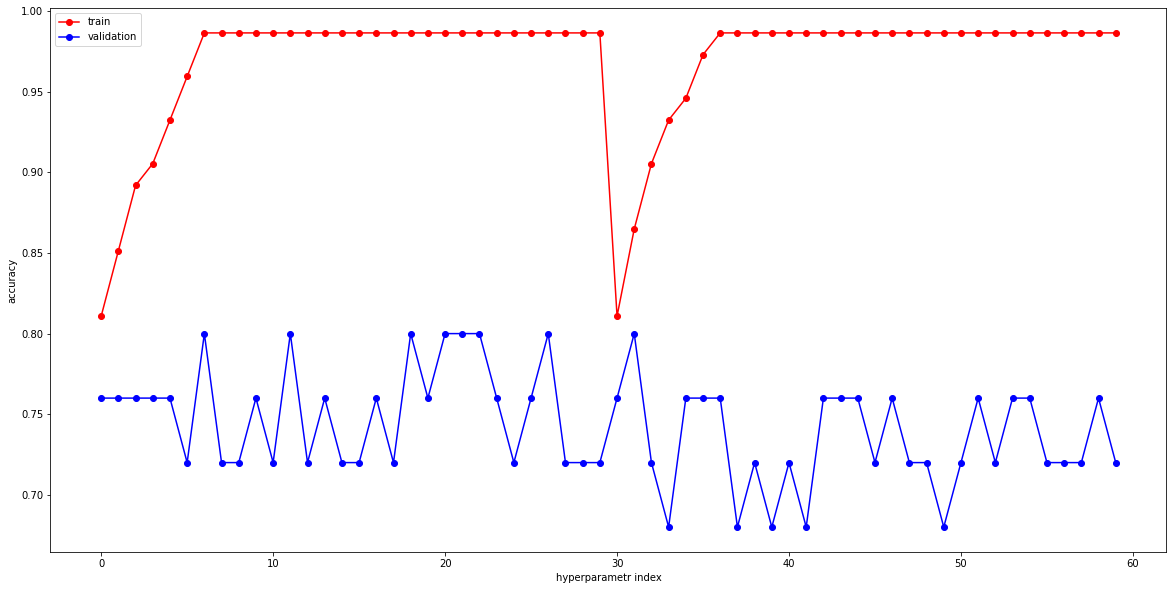

In [52]:
plt.figure(figsize=(20,10))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

In [53]:
best_par = param_comb[np.argmax(val_acc)]

* Test výsledné přesnosti s nejlepšími parametry

In [54]:
dt = DecisionTreeClassifier(**best_par)
dt.fit(Xtrain, ytrain)
print("Train accuracy {}%".format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print("Test accuracy {}%".format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

Train accuracy 0.9864864864864865%
Test accuracy 0.7575757575757576%


# Jak vykreslit strom  

In [55]:
simple_data = pd.read_csv('simple_data.csv', sep=';') # data z přednášky
display(simple_data.head(16)) 
dts = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dts.fit(simple_data.iloc[:,1:],simple_data['T'])

,T,F1,F2,F3
0,1,1,0,0
1,1,0,1,1
2,1,1,0,0
3,1,1,1,1
4,0,0,0,1
5,0,0,1,0
6,0,0,0,1
7,0,1,1,0


DecisionTreeClassifier(criterion='entropy', max_depth=2)

[Text(279.0, 453.0, 'F1 <= 0.5\nentropy = 1.0\nsamples = 8\nvalue = [4, 4]\nclass = y[0]'),
 Text(139.5, 271.8, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]\nclass = y[0]'),
 Text(69.75, 90.59999999999997, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = y[0]'),
 Text(209.25, 90.59999999999997, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]'),
 Text(418.5, 271.8, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [1, 3]\nclass = y[1]'),
 Text(348.75, 90.59999999999997, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = y[1]'),
 Text(488.25, 90.59999999999997, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]')]

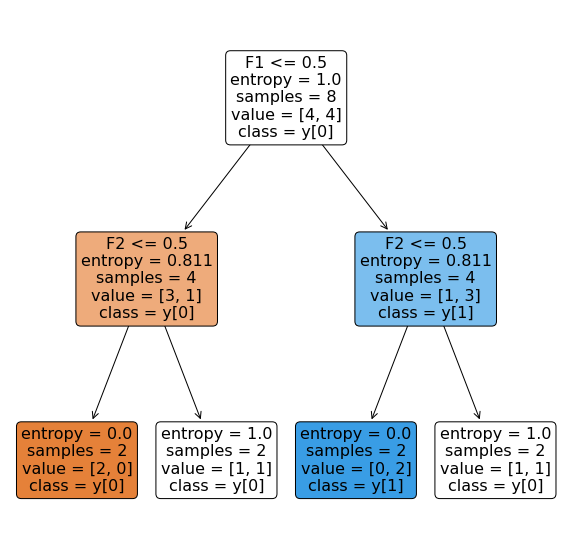

In [56]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(10,10))
plot_tree(dts, filled=True, feature_names=simple_data.iloc[:,1:].columns, class_names=True, rounded=True)


# pro titanik
#plt.figure(figsize=(20,25))
#plot_tree(dt, filled=True, feature_names=Xdata.columns, class_names=["not survived", "survived"], rounded=True)